<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/l5_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ipdb

In [2]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip

--2022-03-02 21:26:48--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip.1’

ml-100k.zip.1       100%[===================>]   4.70M  3.09MB/s    in 1.5s    

2022-03-02 21:26:50 (3.09 MB/s) - ‘ml-100k.zip.1’ saved [4924029/4924029]



In [5]:
!ls

ml-100k.zip  sample_data


In [6]:
!unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [1]:
from fastai import *
from fastai.vision import *
from fastai.collab import *
from ipdb import set_trace as st
import pandas as pd
path = Path('/content/ml-100k')
df = pd.read_csv(path/'u.data', header = None, delimiter = '\t', names = ['u_id', 'm_id', 'rating', 'ts'])
data = CollabDataBunch.from_df(df, user_name = 'u_id', item_name = 'm_id', rating_name = 'rating')
data.show_batch()

u_id,m_id,target
621,313,5.0
435,527,4.0
770,1012,5.0
926,292,3.0
401,493,4.0


epoch,train_loss,valid_loss,abs_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


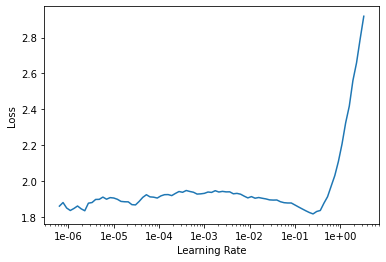

In [88]:
learn = collab_learner(data, n_factors = 40, y_range = [0, 5.5], bn_final = True, wd = 1e-02, metrics = abs_error)
learn.lr_find()
learn.recorder.plot()

In [89]:
learn.fit_one_cycle(5, 1e-03)

epoch,train_loss,valid_loss,abs_error,time
0,1.467766,1.412076,0.980345,00:11
1,0.949733,0.917312,0.761778,00:09
2,0.859378,0.872574,0.738158,00:09
3,0.800778,0.857489,0.730749,00:09
4,0.779291,0.855544,0.729684,00:09


In [55]:
u, m = max(set(df["u_id"])), max(set(df['m_id']))

def abs_error(yhat, y):
  yhat, y = yhat.squeeze(), y.squeeze()
  return torch.mean(torch.abs(yhat - y))

class MyCollab(nn.Module):
  def __init__(self, n_factors, y_range):
    super().__init__()
    nu, ni = u + 1, m + 1
    self.u, self.u_b, self.i, self.i_b = [nn.Embedding(i, j) for i, j in [(nu, n_factors), (nu, 1), (ni, n_factors), (ni, 1)]]
    self.y_range = y_range

  def rangify(self, yhat):
    yhat = torch.sigmoid(yhat)
    # print('d, ', yhat.shape)
    res = (yhat * (self.y_range[1] - self.y_range[0])) + self.y_range[0]
    # print('e, ', res.shape)
    return res

  def forward(self, ud, id):
    # print('a, ', ud.shape, id.shape, max(ud), max(id))
    yhat = torch.sum(self.u(ud) * self.i(id), 1)
    # print('b, ', yhat.shape)
    yhat += self.u_b(ud).squeeze(1) + self.i_b(id).squeeze(1)
    # print('c, ' , yhat.shape)
    return self.rangify(yhat)


In [7]:
x, y = next(iter(data.valid_dl))

In [112]:
collab = MyCollab(40, [0, 5.5]).cuda()
my_learner = CollabLearner(data, collab, metrics = abs_error, wd = 1e-01)

epoch,train_loss,valid_loss,abs_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


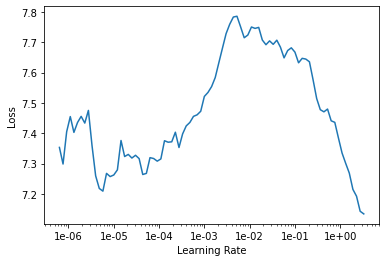

In [113]:
my_learner.lr_find()
my_learner.recorder.plot()

In [114]:
my_learner.save('st_1')

In [115]:
my_learner.load('st_1')
my_learner.fit(3, lr = 1e-02)

epoch,train_loss,valid_loss,abs_error,time
0,1.139574,1.092257,0.827450,00:09
1,0.885973,0.902875,0.756610,00:09
2,0.841115,0.896122,0.752603,00:09


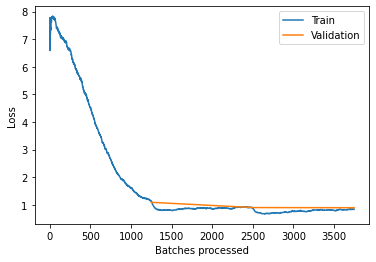

In [116]:
my_learner.recorder.plot_losses()

epoch,train_loss,valid_loss,abs_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


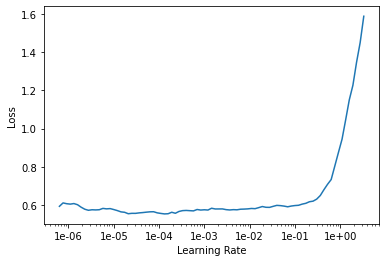

In [117]:
my_learner.lr_find()
my_learner.recorder.plot()

In [118]:
my_learner.save('st_2')

In [122]:
my_learner.load('st_2')
my_learner.fit(3, lr = 5e-04)

epoch,train_loss,valid_loss,abs_error,time
0,0.559931,0.863351,0.739062,00:09
1,0.517758,0.848287,0.732657,00:09
2,0.499348,0.841747,0.729642,00:09


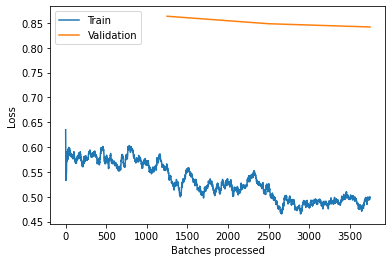

In [123]:
my_learner.recorder.plot_losses()

In [65]:
emb = nn.Embedding(20, 10)

In [70]:
for i in emb.parameters():
  w = i
w.shape

torch.Size([20, 10])

In [72]:
torch.mean(w[0]), torch.mean(w), torch.std(w[0]), torch.std(w)

(tensor(-0.4227, grad_fn=<MeanBackward0>),
 tensor(-0.0238, grad_fn=<MeanBackward0>),
 tensor(0.3475, grad_fn=<StdBackward0>),
 tensor(0.8944, grad_fn=<StdBackward0>))

In [76]:
torch.max(w), torch.min(w)

(tensor(2.4258, grad_fn=<MaxBackward1>),
 tensor(-2.8512, grad_fn=<MinBackward1>))

In [ ]:
with torch.no_grad():
  st()
  emb.weight.normal_()